In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import shutil
import random
from ultralytics import YOLO

In [2]:
# Defining constants
DATASET_DIR = "E:\MyProjects\Garbage management system\ML\data\Garbage_classification"
OUTPUT_YOLO_DIR = "./data/Final_data"  # Path for YOLO-compatible data
YOLO_IMG_SIZE = 416  # Image size for YOLO

In [3]:
class_names = sorted(os.listdir(DATASET_DIR))  # Ensure proper alphabetical order
class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
print("Class Names and Indices:", class_indices)

Class Names and Indices: {'biological': 0, 'cardboard': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


In [4]:
from rembg import remove
import cv2

In [5]:
from rembg import remove
import os

def remove_background(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_output_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            for file_name in os.listdir(class_path):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, file_name)
                    with open(img_path, 'rb') as img_file:
                        input_img = img_file.read()
                        output_img = remove(input_img)
                        with open(os.path.join(class_output_dir, file_name), 'wb') as out_file:
                            out_file.write(output_img)

input_dir = DATASET_DIR
output_dir = "./data/background_removal"
remove_background(input_dir, output_dir)

In [7]:
#Enhancing contrast
def enhance_contrast(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_output_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            for file_name in os.listdir(class_path):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, file_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                        l, a, b = cv2.split(lab)

                        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
                        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                        l_clahe = clahe.apply(l)

                        # Merge channels and convert back to BGR
                        lab_clahe = cv2.merge((l_clahe, a, b))
                        img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

                        # Save enhanced image
                        output_path = os.path.join(class_output_dir, file_name)
                        cv2.imwrite(output_path, img_clahe)

contrast_input_dir = output_dir
contrast_output_dir = "./data/contrast"
enhance_contrast(contrast_input_dir, contrast_output_dir)


In [10]:
#Adjust Lightening
def adjust_lighting(input_dir, output_dir, gamma=1.2):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_output_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            for file_name in os.listdir(class_path):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, file_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Apply gamma correction
                        img_float = img / 255.0
                        img_gamma = cv2.pow(img_float, gamma)
                        img_corrected = np.uint8(img_gamma * 255)

                        # Save adjusted image
                        output_path = os.path.join(class_output_dir, file_name)
                        cv2.imwrite(output_path, img_corrected)

lightening_input_dir = contrast_output_dir
lightening_output_dir = "./data/lightening"
adjust_lighting(lightening_input_dir, lightening_output_dir)


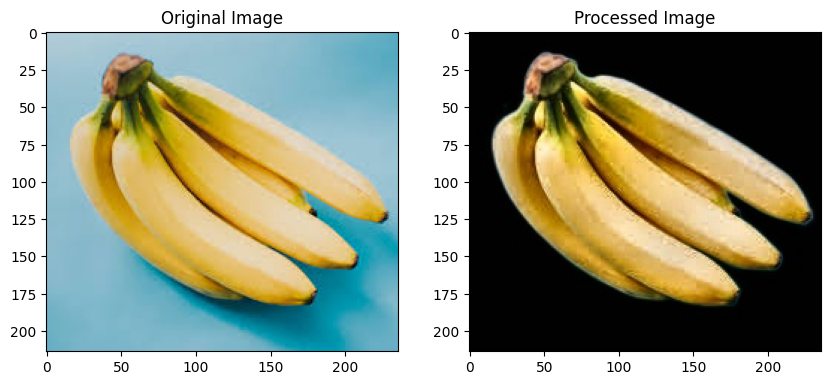

In [11]:
def visualize_pipeline(original_path, final_path):
    original = cv2.imread(original_path)
    final = cv2.imread(final_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image")
    plt.show()

visualize_pipeline(
    original_path= DATASET_DIR+"/biological/biological1.jpg",
    final_path="./data/lightening/biological/biological1.jpg"
)


In [12]:
def resize_images(input_dir, output_dir, target_size=(416, 416)):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_output_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            for file_name in os.listdir(class_path):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, file_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        resized_img = cv2.resize(img, target_size)
                        output_path = os.path.join(class_output_dir, file_name)
                        cv2.imwrite(output_path, resized_img)

resized_nput_dir = lightening_output_dir
resized_output_dir = "./data/resized"
resize_images(resized_nput_dir, resized_output_dir)


In [17]:
#Augmentation
import albumentations as A

def augment_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=3, p=0.2),
        A.RandomRotate90(p=0.5),
        A.RandomGamma(p=0.2),
        A.CoarseDropout(p=0.2, max_holes=3, max_height=16, max_width=16),
    ])

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_output_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            for file_name in os.listdir(class_path):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, file_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        augmented = augmentation(image=img)
                        output_path = os.path.join(class_output_dir, file_name)
                        cv2.imwrite(output_path, augmented["image"])

augmented_input_dir = resized_output_dir
augmented_output_dir = "./data/augmented"
augment_images(augmented_input_dir, augmented_output_dir)


C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydantic\main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [18]:
from collections import Counter

def check_class_balance(input_dir):
    class_counts = {}
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([
                f for f in os.listdir(class_path) 
                if f.endswith(('.jpg', '.png', '.jpeg'))
            ])
    print("Class Distribution:", class_counts)

check_class_balance(augmented_input_dir)


Class Distribution: {'biological': 985, 'cardboard': 891, 'glass': 928, 'metal': 769, 'paper': 895, 'plastic': 861, 'trash': 697}


In [19]:
#Normalize
def normalize_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_output_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            for file_name in os.listdir(class_path):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, file_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        normalized_img = img / 255.0
                        output_path = os.path.join(class_output_dir, file_name)
                        cv2.imwrite(output_path, (normalized_img * 255).astype(np.uint8))


output_dir = "./data/normalized"
normalize_images(augmented_input_dir, output_dir)


In [20]:
#Verification
def verify_dataset(input_dir):
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    try:
                        img = cv2.imread(file_path)
                        if img is None:
                            print(f"Corrupt file: {file_path}")
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")

verification_input_dir = "./data/normalized"
verify_dataset(verification_input_dir)


In [21]:
#Summary
dataset_dir = "./data/normalized"
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Class '{class_name}': {len(os.listdir(class_path))} images")

total_images = sum([len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))])
print(f"Total images in dataset: {total_images}")



Class 'biological': 985 images
Class 'cardboard': 891 images
Class 'glass': 928 images
Class 'metal': 769 images
Class 'paper': 895 images
Class 'plastic': 861 images
Class 'trash': 697 images
Total images in dataset: 6026


Class distribution: {'biological': 985, 'cardboard': 891, 'glass': 928, 'metal': 769, 'paper': 895, 'plastic': 861, 'trash': 697}


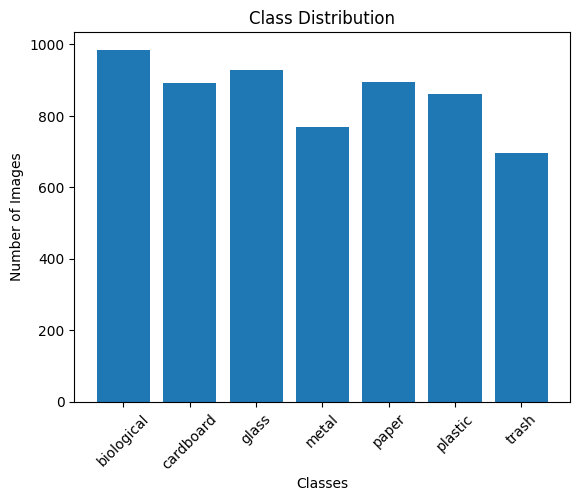

In [22]:
from collections import Counter

class_counts = Counter()
for class_name in os.listdir(dataset_dir):
    class_counts[class_name] += len(os.listdir(os.path.join(dataset_dir, class_name)))
print("Class distribution:", dict(class_counts))

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


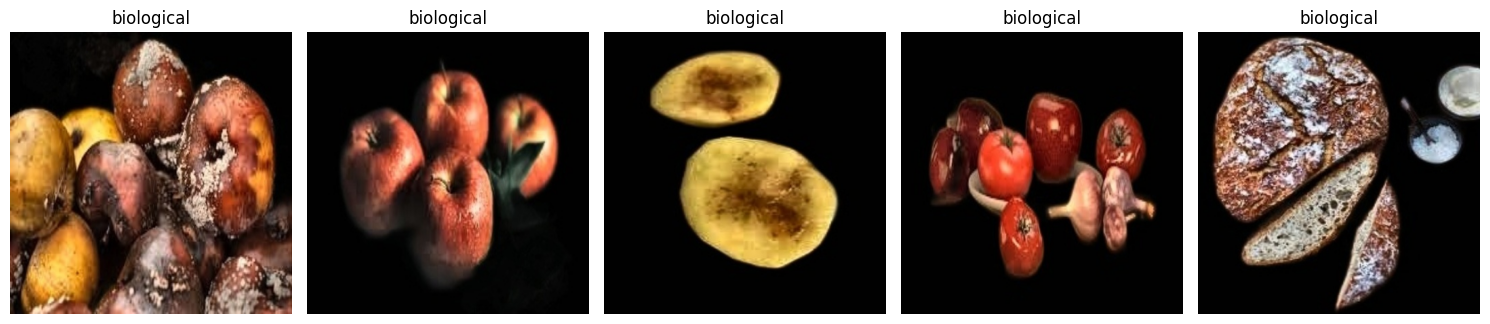

In [26]:
sample_class = random.choice(os.listdir(dataset_dir))
sample_images = random.sample(os.listdir(os.path.join(dataset_dir, sample_class)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(dataset_dir, sample_class, img_name)
    img = cv2.imread(img_path)[:, :, ::-1]  # Convert BGR to RGB
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(sample_class)
plt.tight_layout()
plt.show()


In [27]:
#Image Quality check
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Corrupted image: {img_path}")
        except Exception as e:
            print(f"Error reading {img_path}: {e}")


In [33]:
#Generating Annotations for the dataset
DATASET_DIR = dataset_dir
OUTPUT_LABELS_DIR = "./data/annotations"  # Directory to save generated labels
CLASS_NAMES = ["cardboard", "glass", "metal", "paper", "plastic", "trash", "biological"]

os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)

for class_id, class_name in enumerate(CLASS_NAMES):
    class_folder = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_folder):
        print(f"Skipping {class_name} as folder does not exist.")
        continue
    
    for image_file in os.listdir(class_folder):
        if image_file.lower().endswith(('.jpg', '.png', '.jpeg')):
            label_file = os.path.splitext(image_file)[0] + ".txt"
            label_path = os.path.join(OUTPUT_LABELS_DIR, label_file)
            
            # YOLO annotation format: <class_id> <x_center> <y_center> <width> <height>
            with open(label_path, "w") as f:
                f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")  # Object spans the entire image
            print(f"Annotation created for {image_file}")


Annotation created for cardboard1.jpg
Annotation created for cardboard10.jpg
Annotation created for cardboard100.jpg
Annotation created for cardboard101.jpg
Annotation created for cardboard102.jpg
Annotation created for cardboard103.jpg
Annotation created for cardboard104.jpg
Annotation created for cardboard105.jpg
Annotation created for cardboard106.jpg
Annotation created for cardboard107.jpg
Annotation created for cardboard108.jpg
Annotation created for cardboard109.jpg
Annotation created for cardboard11.jpg
Annotation created for cardboard110.jpg
Annotation created for cardboard111.jpg
Annotation created for cardboard112.jpg
Annotation created for cardboard113.jpg
Annotation created for cardboard114.jpg
Annotation created for cardboard115.jpg
Annotation created for cardboard116.jpg
Annotation created for cardboard117.jpg
Annotation created for cardboard118.jpg
Annotation created for cardboard119.jpg
Annotation created for cardboard12.jpg
Annotation created for cardboard120.jpg
Annot

In [34]:
#Checking class id
import os

LABELS_DIR = OUTPUT_LABELS_DIR

# Check all label files
for label_file in os.listdir(LABELS_DIR):
    if label_file.endswith(".txt"):  # Only process .txt files
        label_path = os.path.join(LABELS_DIR, label_file)
        
        # Read the annotation file
        with open(label_path, 'r') as file:
            lines = file.readlines()

        for line in lines:
            class_id = int(line.split()[0])  # First number in the line is the class_id
            print(f"File: {label_file}, Class ID: {class_id}")


File: biological1.txt, Class ID: 6
File: biological10.txt, Class ID: 6
File: biological100.txt, Class ID: 6
File: biological101.txt, Class ID: 6
File: biological102.txt, Class ID: 6
File: biological103.txt, Class ID: 6
File: biological104.txt, Class ID: 6
File: biological105.txt, Class ID: 6
File: biological106.txt, Class ID: 6
File: biological107.txt, Class ID: 6
File: biological108.txt, Class ID: 6
File: biological109.txt, Class ID: 6
File: biological11.txt, Class ID: 6
File: biological110.txt, Class ID: 6
File: biological111.txt, Class ID: 6
File: biological112.txt, Class ID: 6
File: biological113.txt, Class ID: 6
File: biological114.txt, Class ID: 6
File: biological115.txt, Class ID: 6
File: biological116.txt, Class ID: 6
File: biological117.txt, Class ID: 6
File: biological118.txt, Class ID: 6
File: biological119.txt, Class ID: 6
File: biological12.txt, Class ID: 6
File: biological120.txt, Class ID: 6
File: biological121.txt, Class ID: 6
File: biological122.txt, Class ID: 6
File: 

In [30]:
from sklearn.model_selection import train_test_split


In [36]:
#Splitting the data & making the data Yolo ready
# Paths
OUTPUT_DIR = "./data/Final_data"  # Directory for YOLO-ready data
ANNOTATIONS_DIR = "./data/annotations"  

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1


# Create YOLO directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', split), exist_ok=True)

# Split Data
def split_dataset():
    for class_name in os.listdir(DATASET_DIR):
        class_path = os.path.join(DATASET_DIR, class_name)
        if os.path.isdir(class_path):
            # Collect all images for the class
            images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]
            
            # Split into train, val, and test
            train_images, temp_images = train_test_split(images, test_size=(VAL_RATIO + TEST_RATIO), random_state=42)
            val_images, test_images = train_test_split(temp_images, test_size=(TEST_RATIO / (VAL_RATIO + TEST_RATIO)), random_state=42)

            # Copy images and corresponding labels to the appropriate folders
            for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
                for img_path in split_images:
                    img_name = os.path.basename(img_path)
                    
                    # If annotations are in the same directory as images
                    label_path = os.path.splitext(img_path)[0] + ".txt"
                    
                    # If annotations are in a separate directory
                    if ANNOTATIONS_DIR:
                        label_path = os.path.join(ANNOTATIONS_DIR, os.path.splitext(img_name)[0] + ".txt")
                    
                    # Copy image
                    shutil.copy(img_path, os.path.join(OUTPUT_DIR, 'images', split, img_name))
                    
                    # Copy label
                    if os.path.exists(label_path):
                        shutil.copy(label_path, os.path.join(OUTPUT_DIR, 'labels', split, os.path.basename(label_path)))
                    else:
                        print(f"Label file missing for image: {img_name}")

# Execute split
split_dataset()

print("Dataset split and YOLO data preparation complete!")


Dataset split and YOLO data preparation complete!


In [37]:
model = YOLO('yolov8s.pt')

# Start training the model
model.train(
    data='configuration.yaml',  # Path to YAML file
    epochs=50,                    # Number of epochs you want to train for
    imgsz=416,                    # Image size for training
    batch=16,                     # Batch size
    device=0                      # Use GPU
)


100%|█████████████████████████████████████████████████████████████████████████████| 21.5M/21.5M [00:07<00:00, 2.88MB/s]


New https://pypi.org/project/ultralytics/8.3.48 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.11.9 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=configuration.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:01<00:00, 2.82MB/s]


AMP: checks passed 


train: Scanning E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\labels\train... 4214 images, 0 back


train: New cache created: E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\labels\val... 1206 images, 0 backgrou

val: New cache created: E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\labels\val.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.08G     0.9686      2.196      1.422         17        416: 100%|██████████| 264/264 [03:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17


                   all       1206       1206      0.566      0.588      0.641      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.05G     0.8071      1.539      1.277         17        416: 100%|██████████| 264/264 [02:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.573      0.585      0.607      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.02G     0.7763      1.487      1.255         15        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206       0.62      0.664      0.686      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.03G     0.7052      1.389      1.209         18        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.603      0.679      0.692      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.03G      0.647      1.327      1.184         22        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.655      0.705      0.739      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.02G     0.6442      1.271      1.176         17        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.719      0.716      0.785      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.02G     0.6018      1.221      1.147         12        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.717      0.719      0.789      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.03G      0.552      1.167      1.122         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.732      0.731      0.814       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.03G     0.5544      1.128      1.123         18        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.723      0.718      0.803      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.03G     0.5304      1.112      1.108         20        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.775      0.721      0.827      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.02G     0.5214       1.09      1.104         23        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.761      0.728      0.828      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.02G      0.487      1.048      1.085         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.808      0.759      0.865      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.02G     0.4794      1.025      1.077         16        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.788       0.74      0.849      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.03G     0.4811      1.029      1.091         17        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.807      0.728      0.852      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.03G     0.4612     0.9929      1.076         18        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.789      0.795      0.872      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.03G     0.4653     0.9877      1.077         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.787      0.724       0.84       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.02G     0.4558     0.9696      1.072         15        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.764      0.757      0.862      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.03G     0.4297     0.9443      1.058         24        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.805      0.777       0.87      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.03G     0.4439     0.9529      1.066         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.802      0.767       0.87      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.03G     0.4394     0.9141      1.061         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.802      0.772      0.853      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.03G     0.4347     0.8934      1.063         20        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206       0.87      0.768      0.887      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.02G     0.4166     0.8703       1.05         17        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.828      0.819      0.897       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.03G     0.4143      0.868       1.05         20        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206       0.83      0.819      0.895      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.03G     0.4172     0.8771      1.053         14        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.836      0.819        0.9      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.03G     0.4002     0.8506      1.045         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.842      0.792      0.897      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.03G     0.3926     0.8401       1.04         17        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206       0.86      0.768      0.901      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.03G     0.3893     0.8194      1.042         16        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.872      0.761      0.893      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.03G     0.4015     0.8159      1.052         16        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.858       0.82      0.916      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.02G     0.3725     0.8093      1.035         15        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206       0.86      0.818      0.912      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.03G      0.384     0.8078      1.043         16        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.879      0.833      0.919       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.06G     0.3787     0.7819      1.034         19        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.877      0.835      0.916      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.03G     0.3769     0.7897      1.037         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.872      0.827      0.921      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.02G     0.3744     0.7761      1.035         22        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.876      0.848      0.932      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.03G      0.363     0.7466      1.027         19        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.861      0.865      0.927      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.05G     0.3578     0.7416      1.028         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.874      0.865      0.932      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.03G     0.3591     0.7364      1.024         17        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.905      0.861      0.941      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.02G      0.356     0.7314      1.027         18        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.919      0.836      0.931      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.03G     0.3517     0.7262      1.024         24        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.867      0.853      0.923      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.06G     0.3505     0.7016      1.028         19        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.908      0.857      0.934      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.03G     0.3485     0.6981      1.025         20        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.905      0.852      0.943      0.913


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.02G     0.0666     0.3925     0.9147          6        416: 100%|██████████| 264/264 [02:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18


                   all       1206       1206      0.871      0.883      0.948      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.03G    0.03887     0.2953     0.9062          6        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16

                   all       1206       1206      0.912       0.86      0.951      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.05G    0.03533     0.2737     0.9033          6        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.919       0.89      0.957      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.03G    0.03304      0.262     0.9014          6        416: 100%|██████████| 264/264 [02:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15


                   all       1206       1206      0.907       0.88      0.957      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.02G    0.03078     0.2302     0.9008          6        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.913      0.879      0.957      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.03G    0.02948     0.2024     0.9002          6        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.874      0.905      0.957      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.06G    0.02748      0.185     0.8978          6        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.926      0.889      0.958      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.03G    0.02705       0.18     0.8977          6        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.916      0.894      0.961       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.02G    0.02598     0.1579     0.8951          6        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15


                   all       1206       1206      0.917      0.907      0.962       0.96

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.03G    0.02433     0.1451     0.9006          6        416: 100%|██████████| 264/264 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15

                   all       1206       1206      0.917      0.905      0.962       0.96



50 epochs completed in 2.303 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 22.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.37  Python-3.11.9 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17


                   all       1206       1206      0.917      0.905      0.962       0.96
             cardboard        178        178      0.926      0.916       0.98      0.979
                 glass        186        186      0.872      0.883      0.945      0.943
                 metal        154        154      0.899      0.896      0.946      0.942
                 paper        179        179      0.948      0.909      0.976      0.973
               plastic        172        172      0.923      0.843      0.935       0.93
                 trash        140        140      0.899      0.914      0.964      0.964
            biological        197        197      0.951      0.976       0.99      0.989
Speed: 0.4ms preprocess, 7.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E2E058CA50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [8]:
import pandas

In [5]:
model = YOLO("./runs/detect/train/weights/best.pt")

In [10]:
# Evaluate the model
results = model.val(data='configuration.yaml')  # Path to your dataset YAML file

# View results
print(dir(results))  # Lists all attributes and methods of the results object


Ultralytics 8.3.37  Python-3.11.9 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)


val: Scanning E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\labels\val.cache... 1206 images, 0 ba
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:22


                   all       1206       1206      0.917      0.905      0.963       0.96
             cardboard        178        178      0.926      0.916       0.98      0.979
                 glass        186        186      0.872      0.882      0.945      0.943
                 metal        154        154      0.899      0.896      0.947      0.942
                 paper        179        179      0.948      0.909      0.976      0.973
               plastic        172        172      0.923      0.843      0.936      0.931
                 trash        140        140      0.899      0.914      0.964      0.964
            biological        197        197      0.951      0.975       0.99      0.989
Speed: 0.7ms preprocess, 9.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\val3
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '_

In [21]:
# Assuming 'results' is the object returned from the evaluation step
print("Evaluation Metrics:")

# Overall metrics
print(f"Precision: {results.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {results.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP@0.5: {results.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {results.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Fitness: {results.results_dict['fitness']:.4f}")

# Per-class mAP
print("\nClass-wise mAP:")
class_maps = results.maps
class_names = results.names
for class_id, class_name in class_names.items():
    print(f"{class_name}: {class_maps[class_id]:.4f}")

# Speed metrics
print("\nSpeed Metrics:")
speed_metrics = results.speed
print(f"Preprocessing time: {speed_metrics['preprocess']:.2f} ms")
print(f"Inference time: {speed_metrics['inference']:.2f} ms")
print(f"Postprocessing time: {speed_metrics['postprocess']:.2f} ms")


Evaluation Metrics:
Precision: 0.9169
Recall: 0.9051
mAP@0.5: 0.9626
mAP@0.5:0.95: 0.9602
Fitness: 0.9605

Class-wise mAP:
cardboard: 0.9794
glass: 0.9429
metal: 0.9424
paper: 0.9729
plastic: 0.9315
trash: 0.9637
biological: 0.9890

Speed Metrics:
Preprocessing time: 0.70 ms
Inference time: 9.28 ms
Postprocessing time: 1.67 ms


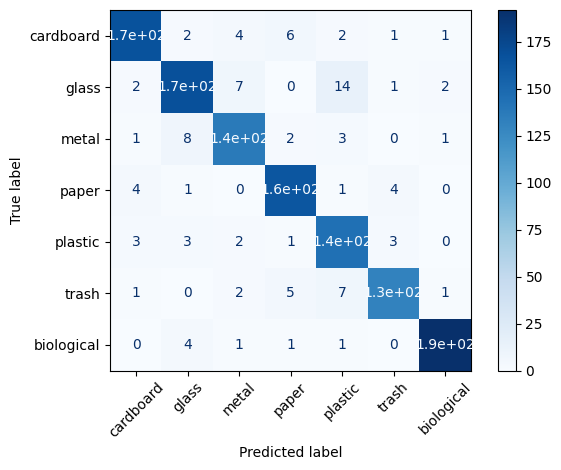

In [51]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

conf_matrix = det_metrics.confusion_matrix.matrix  # Access confusion matrix

# Remove the row/column corresponding to background. This has to be done since a backgroud class is added due to the preprocessing which adds no value to our output
filtered_conf_matrix = conf_matrix[:-1, :-1]

# Align the class names with the filtered matrix
class_names = list(det_metrics.names.values())  # Get class names

# Plot the filtered confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_conf_matrix, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.tight_layout()
plt.show()


In [65]:
from sklearn.metrics import classification_report

In [102]:
# Paths to test images and labels
test_images_path = './data/Final_data/images/test'
test_labels_path = './data/Final_data/labels/test'

# Get the list of test images
img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over test images
for img_name in img_files:
    img_path = os.path.join(test_images_path, img_name)
    
    # Retrieve ground truth labels
    label_name = os.path.splitext(img_name)[0] + '.txt'
    label_path = os.path.join(test_labels_path, label_name)
    
    if not os.path.exists(label_path):
        print(f"Warning: Missing label file for {img_name}, adding placeholder.")
        true_labels.append(-1)  # Placeholder for missing ground truth
    else:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if lines:
                for line in lines:
                    class_id = int(line.split()[0])  # Extract class ID from YOLO format
                    true_labels.append(class_id)
            else:
                true_labels.append(-1)  # Placeholder for images with no labels
    
    # Predict with YOLO
    results = model(img_path)
    predictions = results[0].boxes.cls.cpu().numpy() if len(results[0].boxes) > 0 else []

    if len(predictions) > 0:
        predicted_labels.extend(predictions)
    else:
        predicted_labels.append(-1)  # Placeholder for no predictions

# Check lengths of true_labels and predicted_labels
if len(true_labels) != len(predicted_labels):
    print(f"Mismatch detected: True labels ({len(true_labels)}) vs Predicted labels ({len(predicted_labels)})")

# Adjust lengths if needed (add placeholders to match lengths)
if len(true_labels) > len(predicted_labels):
    predicted_labels.extend([-1] * (len(true_labels) - len(predicted_labels)))
elif len(predicted_labels) > len(true_labels):
    true_labels.extend([-1] * (len(predicted_labels) - len(true_labels)))





image 1/1 E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\images\test\biological100.jpg: 416x416 1 biological, 78.1ms
Speed: 306.7ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\images\test\biological105.jpg: 416x416 1 biological, 32.4ms
Speed: 1.1ms preprocess, 32.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\images\test\biological12.jpg: 416x416 1 biological, 8.2ms
Speed: 15.6ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 E:\MyProjects\Garbage management system\ML\YOLO new\data\Final_data\images\test\biological139.jpg: 416x416 1 biological, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 E:\MyProjects\Garbage management system\ML\YO

In [105]:
# Generate classification report
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash', 'biological', 'no_label_or_prediction']
report = classification_report(
    true_labels, 
    predicted_labels, 
    target_names=class_names, 
    zero_division=1
)

print(report)

                        precision    recall  f1-score   support

             cardboard       1.00      0.00      0.00        11
                 glass       0.96      0.97      0.96        88
                 metal       0.94      0.93      0.94        86
                 paper       0.91      0.93      0.92        73
               plastic       0.86      0.88      0.87        84
                 trash       0.84      0.86      0.85        71
            biological       0.75      0.81      0.78        57
no_label_or_prediction       0.97      0.98      0.97        97

              accuracy                           0.90       567
             macro avg       0.90      0.79      0.79       567
          weighted avg       0.90      0.90      0.89       567

